# Enron Topic Modeling with LDA

## What this notebook demonstrates: 

In this notebook, we will following the process below: 

    1. Data ingest, import packages. 
    
    2. Data transformation: data cleanup, remove stop words, tokenization, lemmatization, and we form bigrams and trigrams. These steps enable us toto boost the signal of our LDA models and weed out noise.

    3. Create an index-to-word mapping dictionary as well as a corpus. The corpus measures term frequency within each document. 

    4. Explore LDA models from Gensim and Mallet packages. Both perform well. We are looking for the most accurate of the two. Both Gensim and Mallet require us to select the number of topics. To tackle this, we will extract Coherence scores from models ranging from 2 - 40 topics and select the model that generated the highest Coherence score. 

    5. After fitting the optimal models to our data, we will visualize the dominant topics and words from each group using pyLDAvis. 

    6. Finally, we will shape our data as a user-topic matrix that will average the topics for each user to obtain a consolidated topic distribution for each person. We shape our data in this way because our goal is to reveal how individuals cluster by looking at what they talk about, and how they relate to each other using social network graph features. 

## I. Data Ingest & Import Packages
We begin the notebook by importing cleaned data from "Email Data Transformation - Enron.ipynb

Note: We will start out the topic modeling process by working with the unexploded version - this will cut down the load of the topic model by working with a smaller dataset. After we select the best topic model and run it against our data, we will then perform the same data transformation steps that we performed in the Graph Setup notebook. 

In [1]:
from platform import python_version

print(python_version())

3.8.3


In [4]:
#Import standard packages
import pandas as pd
import numpy as np
import re
import pickle

#-----------------------------
#NLP Pre-Processing Packages:

# Import nltk for data cleanup steps: 
#conda install nltk
import nltk
nltk.download('stopwords')

# Import spacy for lemmatization
#conda install spacy
import spacy
from spacy.lang.en.examples import sentences

#-----------------------------
#Import gensim package for LDA 
#conda install gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#-----------------------------
#Visualization packages: 
import matplotlib.pyplot as plt

# Enable matplotlib to be plotted in the jupyter notebook without plt.show()
%matplotlib inline

# Import pyLDAvis for plotting LDA model output
#conda install pyLDAvis
!pip install pyLDAvis #<----------- Use for Google Colab
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis #<--- Use for Google Colab
#import pyLDAvis.gensim as gensimvis #<------- Comment this out if on Google Colab

#-----------------------------
#For Colab
#%load_ext google.colab.data_table

#-----------------------------
#Use this to avoid continuous warning messages
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\535508\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The system cannot find the file specified.


ModuleNotFoundError: No module named 'pyLDAvis.gensim_models'

#### Read in data

In [3]:
dataset = pd.read_csv('1_emails.csv', index_col=0)

#keep only From, To, and Body 
cols =['From', 'To','Body']
dataset = pd.DataFrame(dataset, columns=cols)

#Display
print(dataset.shape)
print(dataset.head(2))

(7685, 3)
                    From                                                 To  \
0  steven.kean@enron.com  {'richard.sanders@enron.com', 'james.steffes@e...   
1  soblander@carrfut.com                          {'soblander@carrfut.com'}   

                                                Body  
0  I think the meeting is on Wednesday, but if yo...  
1  Notice # 01-162\nMay 11, 2001\n\nTO:\nAll NYME...  


## II. Data Transformation

### 1. Tokenize
Our first step now that we have the body of the emails is to collect them together. We do this by creating a list. Then, we breakdown each sentence into a list of words (tokens).

In [8]:
#Taking a look at a sample email body: 
dataset.Body.iloc[17]

'Bill,\n\nWe really do not need to delete the books.  We would like to keep them available for possible future trading.  Essentially, additional books are set up for the sole purpose of using them in the future when needed.  At that time, we will assign a trader name to the book.  This will mean that the book is ready to go in GCP as well as ERMS.  Let me know if you have any questions.\n\nJohn\n\n -----Original Message-----\nFrom: \tHare, Bill D.  \nSent:\tTuesday, January 29, 2002 10:34 AM\nTo:\tValdes, John\nSubject:\tFW: Book changes\n\nI forwarded Jon the color coded list I sent to you.  He said that some of the Traders and or Book names would be changed, some Books would be deleted all together.\n\nTalk to you later.\n \nBill\n\n -----Original Message-----\nFrom: \tLewis,  Jon Paul  \nSent:\tTuesday, January 29, 2002 10:17 AM\nTo:\tHare, Bill D.\nSubject:\tBook changes\n\nBill-\n\nKevin Presto gave us a revised list of the traders and their books.  I would say about 50% of what h

In [9]:
# First, convert entire email body to list:
data = dataset.Body.values.tolist()
data[17:19]

['Bill,\n\nWe really do not need to delete the books.  We would like to keep them available for possible future trading.  Essentially, additional books are set up for the sole purpose of using them in the future when needed.  At that time, we will assign a trader name to the book.  This will mean that the book is ready to go in GCP as well as ERMS.  Let me know if you have any questions.\n\nJohn\n\n -----Original Message-----\nFrom: \tHare, Bill D.  \nSent:\tTuesday, January 29, 2002 10:34 AM\nTo:\tValdes, John\nSubject:\tFW: Book changes\n\nI forwarded Jon the color coded list I sent to you.  He said that some of the Traders and or Book names would be changed, some Books would be deleted all together.\n\nTalk to you later.\n \nBill\n\n -----Original Message-----\nFrom: \tLewis,  Jon Paul  \nSent:\tTuesday, January 29, 2002 10:17 AM\nTo:\tHare, Bill D.\nSubject:\tBook changes\n\nBill-\n\nKevin Presto gave us a revised list of the traders and their books.  I would say about 50% of what 

In [10]:
# Function to tokenize (break down each sentence into a list of words) each sentence using gensim 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  
        # deacc=True removes punctuations
        
#Apply the function to our data: 
data_words = list(sent_to_words(data))

In [11]:
#See an example
print(data_words[17])

['bill', 'we', 'really', 'do', 'not', 'need', 'to', 'delete', 'the', 'books', 'we', 'would', 'like', 'to', 'keep', 'them', 'available', 'for', 'possible', 'future', 'trading', 'essentially', 'additional', 'books', 'are', 'set', 'up', 'for', 'the', 'sole', 'purpose', 'of', 'using', 'them', 'in', 'the', 'future', 'when', 'needed', 'at', 'that', 'time', 'we', 'will', 'assign', 'trader', 'name', 'to', 'the', 'book', 'this', 'will', 'mean', 'that', 'the', 'book', 'is', 'ready', 'to', 'go', 'in', 'gcp', 'as', 'well', 'as', 'erms', 'let', 'me', 'know', 'if', 'you', 'have', 'any', 'questions', 'john', 'original', 'message', 'from', 'hare', 'bill', 'sent', 'tuesday', 'january', 'am', 'to', 'valdes', 'john', 'subject', 'fw', 'book', 'changes', 'forwarded', 'jon', 'the', 'color', 'coded', 'list', 'sent', 'to', 'you', 'he', 'said', 'that', 'some', 'of', 'the', 'traders', 'and', 'or', 'book', 'names', 'would', 'be', 'changed', 'some', 'books', 'would', 'be', 'deleted', 'all', 'together', 'talk', 't

In [12]:
#How many words are in this example? 
len(data_words[17])

211

### 2. Remove Stopwords

Now we will remove stopwords. These are words such as "as", "the", "and" and "to" that do not add any meaning to our content. We also extend the stopword list to words such as "subject", "thanks", "from", etc. which are not included in NLTK's stopword corpus but are also meaningless to the overall meaning of the messages we are analyzing. 

Remember, we want to remove as much noise from our emails so we can get to the core theme of the message. You can think of this as "boosting the signal" of our email messages by keeping only what is valuable. Removing stopwords is the first step we will take in this process of removing noise.  

In [13]:
#Prep NLTK stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['ee', 'td', 'doc', 'asp', 'br', 'subject', 'tr', 'pm', 'html', 'from', 'click', 'thanks', 'corp', 'www', 'aol', 'thank', 'sa', 'image', 'hotmail', 'forwarded', 'http', 'fyi', 'hou', 'gif', 'link', 'cc', 'am', 'href', 'yahoo', 'bcc', 'mailto', 'com', 'use', 'edu', 'etc', 'pdf', 'arial', 'page', 'net', 'et', 'font', 're'])

In [14]:
def remove_stopwords(texts): 
    return[[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#Apply to corpus: 
data_words_nostops = remove_stopwords(data_words)

In [15]:
#Look at an example: 
print(data_words_nostops[17])

['bill', 'really', 'need', 'delete', 'books', 'would', 'like', 'keep', 'available', 'possible', 'future', 'trading', 'essentially', 'additional', 'books', 'set', 'sole', 'purpose', 'using', 'future', 'needed', 'time', 'assign', 'trader', 'name', 'book', 'mean', 'book', 'ready', 'go', 'gcp', 'well', 'erms', 'let', 'know', 'questions', 'john', 'original', 'message', 'hare', 'bill', 'sent', 'tuesday', 'january', 'valdes', 'john', 'fw', 'book', 'changes', 'jon', 'color', 'coded', 'list', 'sent', 'said', 'traders', 'book', 'names', 'would', 'changed', 'books', 'would', 'deleted', 'together', 'talk', 'later', 'bill', 'original', 'message', 'lewis', 'jon', 'paul', 'sent', 'tuesday', 'january', 'hare', 'bill', 'book', 'changes', 'bill', 'kevin', 'presto', 'gave', 'us', 'revised', 'list', 'traders', 'books', 'would', 'say', 'set', 'changed', 'due', 'large', 'number', 'changes', 'would', 'best', 'delete', 'created', 'start', 'send', 'revised', 'list', 'make', 'changes', 'please', 'let', 'us', 'k

In [16]:
#How many words do we have now? 
len(data_words_nostops[17])

113

We see that by removing stopwords, we have deleted 98 words from this email (211 original words - 113 remaining words = 98 words deleted from email #17)

### 3. N-Grams: Tokens that Flock Together

We can further "boost our data signal" by creating N-grams in our dataset. Our knowledge of language gives us the intuition that when two or three words consistently go together (side by side), there is a richer meaning conveyed than with each individual word.

For example, the word grouping "traffic light" carries slightly different meaning as opposed to if the words were inspected independently as "traffic" and "light".

To extract this level of information we create what is called bigrams and trigrams. The former being grouping of two adjacent words. The latter being three adjacent words.

Gensim gives us some nice APIs to manage this. As you can see below we can inspect the output of applying bigrams and trigrams.

In [17]:
from gensim.models.phrases import Phrases, Phraser

In [18]:
#Build the bigram and trigram models (This will take a few moments): 
bigram = Phrases(data_words, min_count=5, threshold=100)
trigram = Phrases(bigram[data_words], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [19]:
#Functions to apply bigram_mod and trigram_mod to all rows: 
def make_bigrams(texts):
    return[bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return[trigram_mod[bigram_mod[doc]] for doc in texts]

In [20]:
#Apply function to form bigrams 
data_words_bigrams = make_bigrams(data_words_nostops)

In [21]:
#Look at an example: 
print(data_words_bigrams[17])

['bill', 'really', 'need', 'delete', 'books', 'would', 'like', 'keep', 'available', 'possible', 'future', 'trading', 'essentially', 'additional', 'books', 'set', 'sole', 'purpose', 'using', 'future', 'needed', 'time', 'assign', 'trader', 'name', 'book', 'mean', 'book', 'ready', 'go', 'gcp', 'well', 'erms', 'let', 'know', 'questions', 'john', 'original_message', 'hare', 'bill', 'sent', 'tuesday', 'january', 'valdes', 'john', 'fw', 'book', 'changes', 'jon', 'color', 'coded', 'list', 'sent', 'said', 'traders', 'book', 'names', 'would', 'changed', 'books', 'would', 'deleted', 'together', 'talk', 'later', 'bill', 'original_message', 'lewis', 'jon', 'paul', 'sent', 'tuesday', 'january', 'hare', 'bill', 'book', 'changes', 'bill', 'kevin_presto', 'gave', 'us', 'revised', 'list', 'traders', 'books', 'would', 'say', 'set', 'changed', 'due', 'large', 'number', 'changes', 'would', 'best', 'delete', 'created', 'start', 'send', 'revised', 'list', 'make', 'changes', 'please', 'let', 'us', 'know', 'wo

In [22]:
#How many words do we have now? 
len(data_words_bigrams[17])

110

Our bigram function combined "original" and "message" into "original_message" in two places and combined the name "kevin" with "presto". Now we have gone from 113 to 110 words in email #17

### 4a. Lemmatization -- getting to the base word
We can do a lot to amplify the signal of our messages by boiling words down to the base word. For example, let us consider these three words:

    Running
    Ran
    Run

They are all communicating a similar idea and can all be boiled down to a single base word, which in this case would be Run. This base word is called the lemma.

Spacy gives us a way to do this with the flexibility to restrict this to different parts of speech as well. 

### 4b. Parts of Speech

In the same step, we will also restrict our dataset to extracting certain parts of speech. For this project, we will extract Nouns, Adjectives, Verbs, and Adverbs. You are welcome (and encouraged!) to try different combinations and see how the results change. When running the model on the full dataset, the method below produced the best results. 

In [20]:
#At the terminal/command line: python -m spacy download en

In [21]:
nlp = spacy.load("en_core_web_sm")

In [22]:
#Initialize a spacy "en_core_web_sm" model, keeping only tagger component
spacy_mod = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [23]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = spacy_mod(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:
# Do lemmatization keeping only noun, adj, vb, adv (*****This step takes 1-9 minutes to run *****)
data_lemmatized = lemmatization(data_words_bigrams)

In [25]:
#look at example: 
print(data_lemmatized[17])

['bill', 'really', 'need', 'delete', 'book', 'keep', 'available', 'possible', 'future', 'trading', 'essentially', 'additional', 'book', 'set', 'sole', 'purpose', 'use', 'future', 'need', 'time', 'assign', 'trader', 'name', 'book', 'mean', 'book', 'ready', 'go', 'gcp', 'erm', 'let', 'know', 'question', 'john', 'original_message', 'hare', 'bill', 'send', 'tuesday', 'january', 'valde', 'john', 'book', 'change', 'jon', 'color', 'code', 'list', 'send', 'say', 'trader', 'book', 'name', 'change', 'book', 'delete', 'together', 'talk', 'later', 'bill', 'original_message', 'lewis', 'jon', 'paul', 'send', 'tuesday', 'january', 'hare', 'bill', 'book', 'change', 'bill', 'give', 'revise', 'list', 'trader', 'book', 'say', 'set', 'change', 'due', 'large', 'number', 'change', 'well', 'delete', 'create', 'start', 'send', 'revise', 'list', 'make', 'change', 'let', 'know', 'like']


In [26]:
#How many words are in our example now? 
print(len(data_lemmatized[17]))

96


In [27]:
'''#Save off data_lemmatized and import in next step
with open("1_data_lemmatized.txt", "wb") as fp:   #Pickling
    pickle.dump(data_lemmatized, fp)
'''

'#Save off data_lemmatized and import in next step\nwith open("1_data_lemmatized.txt", "wb") as fp:   #Pickling\n    pickle.dump(data_lemmatized, fp)\n'

Our original message of 211 words now has 77 words! 

We are now ready to transform our dataset into a bag-of-words that will be used to create topic models. 

### 5. Create a Dictionary and Corpus (Bag of Words)

Keep in mind that our algorithms at their core operate on mathematical calculations. Processing our text then requires us to represent the tokens and text numerically. One common way to manage this is by creating an index to word mapping. This allows us to use a look-up table of sorts to map tokens to numbers/index.

We can use the Gensim corpora dictionary API to accomplish this. The output of this is a dictionary.

Next, we need to apply this dictionary factoring term frequency to all our text to create a corpus. This way as we process a token we get a sense of its weight in the document.

The resulting corpus will be passed in as input when creating our LDA model. The doc2bow API converts each text into a bag-of-words format.

Each time we now see a token in a text, information on its frequency is paired with it. A word/token like "contract" could then be represented as (6, 3) — >(token_id, token_count).

In [23]:
#*********If you skiped the pre-processing steps, run this code. If not, you can skip*************
with open("1_data_lemmatized.txt", "rb") as fp:   
    data_lemmatized = pickle.load(fp)

In [24]:
#First we create a dictionary of word mappings for our model (required for Gensim models): 
id2word = corpora.Dictionary(data_lemmatized)

In [25]:
# View a sample from the dictionary we created. This is our index-to-word mapping: 
{k: id2word[k] for k in list(id2word)[:10]}

{0: 'able',
 1: 'act',
 2: 'administrator_directly',
 3: 'aes',
 4: 'agenda',
 5: 'also',
 6: 'antitrust',
 7: 'attend',
 8: 'available',
 9: 'base'}

In [26]:
#Create the Term Document Frequency Bag-of-words: 
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

In [27]:
#Now look at how email #17 is represented: 
print(corpus[17])

[(8, 1), (57, 1), (82, 2), (87, 1), (91, 2), (92, 1), (119, 2), (135, 1), (156, 4), (161, 1), (171, 1), (185, 1), (194, 6), (218, 3), (236, 1), (254, 1), (285, 5), (392, 1), (427, 2), (461, 1), (505, 1), (552, 2), (593, 1), (637, 2), (640, 2), (697, 1), (859, 2), (868, 2), (904, 1), (916, 9), (928, 1), (973, 2), (1002, 1), (1113, 1), (1114, 1), (1115, 1), (1116, 1), (1117, 3), (1118, 1), (1119, 1), (1120, 1), (1121, 2), (1122, 2), (1123, 1), (1124, 1), (1125, 1), (1126, 1), (1127, 1), (1128, 1), (1129, 1), (1130, 2), (1131, 1), (1132, 1), (1133, 3), (1134, 2), (1135, 1)]


## III. Topic Modeling with Gensim LDA: 

### 1. Determine the Optimal Number of Topics

Both Gensim (and later we will see Mallet) LDA models expect you to pass in the number of expected topics as input. How do you figure out what this should be? Coherence scores actual give us a good clue. We want this score to be as high as possible for the most number of topics. Coherence tries to quantify the semantic similarities of the high scoring words within each topic. A high score means the result is more human-interpretable. So, naturally higher coherence score means a better model.

We will run through a variety of topic numbers to observe what this does to the coherence score. Starting with two topics you can see what our score looks like. As you gradually increase this value you can see how this impacts the coherence value.


In [28]:
#Function to find the best coherence value for a span of topic amounts using Gensim's LdaModel and Coherence Model: 
def compute_coherence_values(dictionary, corpus, texts, limit=40, minimum_probability = 0.0, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=101, minimum_probability=0.0, iterations=40)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
# Run the model (*********This takes about 2 minutes to run **************)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, minimum_probability = 0.0, start=12, limit=31, step=6)

Next we show the results on a chart. We are looking for the lowest number of topics that correspond to the highest coherence score. 

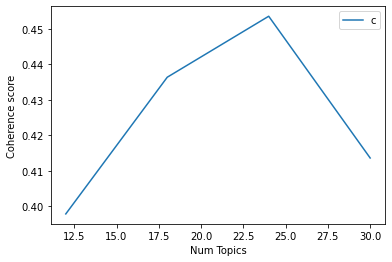

In [30]:
#Plot
limit=31; start=12; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
# Print the coherence scores. 
#Note: we are looking for the highest score (or the coherence score assoc with the elbow in the above chart)
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 12  has Coherence Value of 0.3978
Num Topics = 18  has Coherence Value of 0.4364
Num Topics = 24  has Coherence Value of 0.4536
Num Topics = 30  has Coherence Value of 0.4136


### 2. Observe the Model with the highest coherence score: 

#### 2a. Print the topics

In [32]:
optimal_mod = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=24, id2word=id2word, random_state=101, minimum_probability=0.0, iterations=80)
optimal_mod.show_topics(num_words=10)

[(17,
  '0.007*"flash" + 0.006*"plane" + 0.006*"send" + 0.005*"peterson" + 0.005*"know" + 0.004*"mail" + 0.004*"exclusivity" + 0.004*"newco" + 0.003*"get" + 0.003*"bridgeline"'),
 (19,
  '0.027*"say" + 0.026*"state" + 0.025*"power" + 0.019*"california" + 0.014*"energy" + 0.011*"electricity" + 0.009*"davis" + 0.008*"utility" + 0.007*"price" + 0.005*"plant"'),
 (21,
  '0.022*"pira" + 0.010*"make" + 0.009*"energy" + 0.009*"enron" + 0.009*"employee" + 0.009*"fund" + 0.009*"california" + 0.008*"consumer" + 0.008*"amanda" + 0.008*"bill"'),
 (20,
  '0.049*"ee" + 0.024*"send" + 0.013*"enron" + 0.010*"know" + 0.008*"let" + 0.008*"original_message" + 0.007*"thursday" + 0.006*"comment" + 0.006*"november" + 0.006*"get"'),
 (12,
  '0.016*"enron" + 0.016*"transaction" + 0.014*"know" + 0.012*"number" + 0.012*"date" + 0.011*"let" + 0.011*"volume" + 0.009*"gas" + 0.009*"meeting" + 0.008*"question"'),
 (10,
  '0.025*"enron" + 0.018*"request" + 0.012*"ee" + 0.008*"approval" + 0.007*"final_sc_id" + 0.007*

#### 2b. Send topics to a text file for better visibility: 

In [33]:
gensim_topics = optimal_mod.show_topics(num_topics=24, num_words=15)

f = open('gensim_topics.txt', 'w')
for t in gensim_topics:
    f.write(' '.join(str(s) for s in t) + '\n\n')
f.close()

#### 2c. Visualize the  topics:
    The size of the bubbles tells us how dominant a topic is across all the documents (our corpus)

    The words on the right are the keywords driving that topic

    The closer the bubbles the more similar the topic. The farther they are apart the less similar

    Preferably, we want non-overlapping bubbles as much as possible spread across the chart.

In [34]:
#pyLDAvis.enable_notebook(sort=True)
#vis = gensimvis.prepare(optimal_mod, corpus, id2word)
#pyLDAvis.display(vis)

#### Very nice visualization! 
Check out topics #2, #5 and #6 by hovering over the bubbles with those numbers . The Enron scandal was, among other things, centered around rigging California's energy grid to have rolling blackouts. Enron then dramatically raised energy prices and sold it back to California at exorbitant prices. People across the state could not afford their energy bills. Enron created the crisis and then sold a solution at a grossly elevated price. 

## IV. Create a Topics Feature Matrix

### 1. Format topic distribution of documents into a dataframe

In [35]:
#Apply the model to our corpus: 
doc_optimal_model = optimal_mod[corpus]

In [36]:
#Look at the topic distribution of our sample email: 
doc_optimal_model[17]

[(0, 0.00042971794),
 (1, 0.00042971794),
 (2, 0.6166192),
 (3, 0.170563),
 (4, 0.20379375),
 (5, 0.00042971794),
 (6, 0.00042971794),
 (7, 0.00042971794),
 (8, 0.00042971794),
 (9, 0.00042971794),
 (10, 0.00042971794),
 (11, 0.00042971794),
 (12, 0.00042971794),
 (13, 0.00042971794),
 (14, 0.00042971794),
 (15, 0.00042971794),
 (16, 0.00042971794),
 (17, 0.00042971794),
 (18, 0.00042971794),
 (19, 0.00042971794),
 (20, 0.00042971794),
 (21, 0.00042971794),
 (22, 0.00042971794),
 (23, 0.00042971794)]

In [37]:
def model_to_features(model):
    '''
    Function to convert LDA model result to dataframe format
    '''
    
    #Step1: Take the model and create a list of list of tuples for each document: 
    model_docs=[]
    for m in model:
        model_docs.append(m)
     
    
    #Step2: Shape this into a dictionary so we can prepare for dataframe: 
    model_dict={}
    for num, item in enumerate(model_docs):
        nested_dict={}
        for topic, score in item:
            nested_dict.setdefault(topic, []).append(score)
        model_dict[num]=nested_dict
        
    print('Here is a slice of our dictionary: \n')
    print({k: model_dict[k] for k in list(model_dict)[:3]})
    
    
    #Step3: Create a features dataframe from the dict: 
    features_df = pd.DataFrame(model_dict).transpose()    
  
#This step is only necessary if your dataframe values are in list format
    #Step4: Covert the values in the dataframe from lists to float: 
    ncol = features_df.shape[1]
    for cols in features_df.columns:
        if cols in np.arange(start=0, stop=ncol):
            features_df[cols] = features_df[cols].apply(lambda x: x[0]).astype(float)
            
    return features_df

In [38]:
#Apply function to our model to create a df: 
features_df = model_to_features(doc_optimal_model)

Here is a slice of our dictionary: 

{0: {0: [0.18748899], 1: [0.00016746143], 2: [0.00016746143], 3: [0.00016746143], 4: [0.00016746143], 5: [0.00016746143], 6: [0.6492852], 7: [0.06433119], 8: [0.03787426], 9: [0.00016746143], 10: [0.057838608], 11: [0.00016746143], 12: [0.00016746143], 13: [0.00016746143], 14: [0.00016746143], 15: [0.00016746143], 16: [0.00016746143], 17: [0.00016746143], 18: [0.00016746143], 19: [0.00016746143], 20: [0.00016746143], 21: [0.00016746143], 22: [0.00016746143], 23: [0.00016746143]}, 1: {0: [0.0002499377], 1: [0.0002499377], 2: [0.0002499377], 3: [0.0002499377], 4: [0.0002499377], 5: [0.0002499377], 6: [0.0002499377], 7: [0.036103867], 8: [0.0002499377], 9: [0.0002499377], 10: [0.0002499377], 11: [0.25800025], 12: [0.0002499377], 13: [0.0002499377], 14: [0.0002499377], 15: [0.0002499377], 16: [0.56631285], 17: [0.0002499377], 18: [0.0002499377], 19: [0.0002499377], 20: [0.100923456], 21: [0.0002499377], 22: [0.0002499377], 23: [0.03391081]}, 2: {0: [6.8

In [39]:
print(features_df.head())

         0         1         2         3         4         5         6   \
0  0.187489  0.000167  0.000167  0.000167  0.000167  0.000167  0.649285   
1  0.000250  0.000250  0.000250  0.000250  0.000250  0.000250  0.000250   
2  0.000068  0.039355  0.000068  0.007423  0.000068  0.004694  0.063984   
3  0.000516  0.000516  0.524279  0.000516  0.000516  0.000516  0.000516   
4  0.001839  0.001839  0.001839  0.001839  0.001839  0.001839  0.001839   

         7         8         9   ...        14        15        16        17  \
0  0.064331  0.037874  0.000167  ...  0.000167  0.000167  0.000167  0.000167   
1  0.036104  0.000250  0.000250  ...  0.000250  0.000250  0.566313  0.000250   
2  0.056898  0.000068  0.000068  ...  0.000068  0.000068  0.000068  0.000068   
3  0.000516  0.000516  0.106039  ...  0.000516  0.000516  0.000516  0.000516   
4  0.001839  0.001839  0.001839  ...  0.001839  0.001839  0.001839  0.001839   

         18        19        20        21        22        23  
0  0

### 2.  Merge the features matrix with our original dataset

In [40]:
print(dataset.head())

                       From  \
0     steven.kean@enron.com   
1     soblander@carrfut.com   
2   jeff.dasovich@enron.com   
3  diana.scholtes@enron.com   
4    phillip.love@enron.com   

                                                  To  \
0  {'richard.sanders@enron.com', 'james.steffes@e...   
1                          {'soblander@carrfut.com'}   
2  {'angela.schwarz@enron.com', 'skean@enron.com'...   
3  {'anne_snyder@pgn.com', 'bill_casey@pgn.com', ...   
4  {'jad.doan@enron.com', 'bruce.mills@enron.com'...   

                                                Body  
0  I think the meeting is on Wednesday, but if yo...  
1  Notice # 01-162\nMay 11, 2001\n\nTO:\nAll NYME...  
2  ----- Forwarded by Jeff Dasovich/NA/Enron on 0...  
3  All days listed below have been corrected.  I ...  
4  The barbque(Chuck that is texas slang for meat...  


In [41]:
dataset.reset_index(drop=True, inplace=True)

In [42]:
topic_features_df = pd.concat([dataset, features_df], axis=1)
topic_features_df.reset_index()

print(topic_features_df.shape)
print(topic_features_df.head())

(7685, 27)
                       From  \
0     steven.kean@enron.com   
1     soblander@carrfut.com   
2   jeff.dasovich@enron.com   
3  diana.scholtes@enron.com   
4    phillip.love@enron.com   

                                                  To  \
0  {'richard.sanders@enron.com', 'james.steffes@e...   
1                          {'soblander@carrfut.com'}   
2  {'angela.schwarz@enron.com', 'skean@enron.com'...   
3  {'anne_snyder@pgn.com', 'bill_casey@pgn.com', ...   
4  {'jad.doan@enron.com', 'bruce.mills@enron.com'...   

                                                Body         0         1  \
0  I think the meeting is on Wednesday, but if yo...  0.187489  0.000167   
1  Notice # 01-162\nMay 11, 2001\n\nTO:\nAll NYME...  0.000250  0.000250   
2  ----- Forwarded by Jeff Dasovich/NA/Enron on 0...  0.000068  0.039355   
3  All days listed below have been corrected.  I ...  0.000516  0.000516   
4  The barbque(Chuck that is texas slang for meat...  0.001839  0.001839   

        

### 3. Convert the Topic Distribution Assignments to Apply to Each Person 

Because we have self-loops in our dataset, and our email addresses still have issues with cleaning, we will Explode the dataset twice. Here are the steps we will take:  

    1. Explode on the To column, since there are often many recipients on a single email. We will need to do some datatype conversions to enable this, then we can explode 

    2, Clean up the email addresses that are in the To and From fields
    
    3. Remove self-loops (we don't want to double-count our topics when a sender copies themselves on their emails). 
    
    4. Merge the From and To columns to a Person column
    
    5. Explode the dataset on the Person column, as this is the target of our investigation. 
    
    6. Group the dataset on the Person column, taking the mean of the topic distribution scores for each person. This way, we will get a distribution PER PERSON of topics discussed. We will be able to see which topics dominate their conversations.
    
Let's begin!    

In [43]:
#Cleanup helper functions: 
    
#Round 1 cleanup function
def clean_to(item):
    return re.sub(r'[^\w/@/.]', '', item)

#Round 2 cleanup function
punc = '"-"\''

def clean_punc(item):
    for element in item:
        if element in punc:
            return item.replace(element, "")
        else:
            return item   

In [44]:
#Rearrange the data

#Make a new dataframe to store our exploded results: 
topic_features_exploded = topic_features_df.copy()
topic_features_exploded = topic_features_exploded.drop(['Body'], axis=1)

#Convert the values in the To column to a list: 
topic_features_exploded['To'] = topic_features_exploded['To'].apply(lambda x: x.split(','))

#Create a weight normalizer, just in case we want to apply this to our topic model at a later time
topic_features_exploded['Weighted_To'] = 1/(topic_features_exploded['To'].apply(lambda x: len(x)))

#Explode: 
topic_features_exploded = topic_features_exploded.explode(column = 'To')
print(topic_features_exploded.shape)

#Make a not-clean copy for troubleshooting
topic_features_exploded_notclean = topic_features_exploded.copy()

#First round of punctuation cleanup
topic_features_exploded['To'] = topic_features_exploded['To'].apply(clean_to)
topic_features_exploded['From'] = topic_features_exploded['From'].apply(clean_to)

#Convert to lowercase:
topic_features_exploded['From'] = topic_features_exploded['From'].str.lower()
topic_features_exploded['To'] = topic_features_exploded['To'].str.lower()

#Manual Entity Resolution on persons-of-interest: 
jeff_mail = ['jeffrey.skilling@enron.com', 'jeff.jeff.skilling@enron.com', 'jeff_skilling@enron.com','jeffrey.k.skilling@enron.com','jeffrey_skilling@enron.com', 'jskilling@enron.com','skillingj@enron.com', 'skilling@enron.com','eff_skilling@enron.com','effrey_skilling@enron.com', 'effrey.skilling@enron.com','jeffreyskilling@yahoo.com']
ken_mail = ['layk@enron.com','k_lay@enron.com', 'klay@enron.com', 'kenneth.l.lay@enron.com','kenlay@enron.com','kennethlay@enron.com','kenneth_lay@enron.com','ken.lay@enron.com','lay.kenneth@enron.com','klay.enron@enron.com','k.lay@enron.com','ken_lay@enron.net','ken_lay@enron.com','kenneth.lay@enron.com','k.l.lay@enron.com','kenneth_lay@enron.net']
andy_mail = ['s..fastow@enron.com','andrew.s.fastow@enron.com', 'andy.fastow@enron.com','fastow@enron.com']
lou_mail = ['lpai@enron.com', 'lou.l.pai@enron.com']
cliff_mail = ['cbaxter@enron.com']

topic_features_exploded['From'] = topic_features_exploded['From'].replace(jeff_mail, 'jeff.skilling@enron.com')
topic_features_exploded['To'] = topic_features_exploded['To'].replace(jeff_mail, 'jeff.skilling@enron.com')

topic_features_exploded['From'] = topic_features_exploded['From'].replace(ken_mail, 'kenneth.lay@enron.com')
topic_features_exploded['To'] = topic_features_exploded['To'].replace(ken_mail, 'kenneth.lay@enron.com')

topic_features_exploded['From'] = topic_features_exploded['From'].replace(andy_mail, 'andrew.fastow@enron.com')
topic_features_exploded['To'] = topic_features_exploded['To'].replace(andy_mail, 'andrew.fastow@enron.com')

topic_features_exploded['From'] = topic_features_exploded['From'].replace(lou_mail, 'lou.pai@enron.com')
topic_features_exploded['To'] = topic_features_exploded['To'].replace(lou_mail, 'lou.pai@enron.com')

topic_features_exploded['From'] = topic_features_exploded['From'].replace(cliff_mail, 'cliff.baxter@enron.com')
topic_features_exploded['To'] = topic_features_exploded['To'].replace(cliff_mail, 'cliff.baxter@enron.com')

#2nd round of punctuation cleanup: 
topic_features_exploded['From'] = topic_features_exploded['From'].apply(clean_punc)
topic_features_exploded['To'] = topic_features_exploded['To'].apply(clean_punc)

#Remove Self-Loops (if a sender copied him/herself to the email chain)
full_topic_features = topic_features_exploded[topic_features_exploded['From'] != topic_features_exploded['To']]

#Concatenate From and To columns into a new column and explode the dataset again
full_topic_features['Person'] = full_topic_features['From'] + ' , ' + full_topic_features['To']
#Convert the string to a list: 
full_topic_features['Person'] = full_topic_features.Person.apply(lambda x: x.split(' , '))

#Explode on Person: 
final_topic_features = full_topic_features.explode('Person')

print(final_topic_features.shape)

(57129, 27)


<ipython-input-44-97233560dc36>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_topic_features['Person'] = full_topic_features['From'] + ' , ' + full_topic_features['To']


(113058, 28)


<ipython-input-44-97233560dc36>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_topic_features['Person'] = full_topic_features.Person.apply(lambda x: x.split(' , '))


In [45]:
#Group by each person and take the average topic distribution: 
final_topic_features = final_topic_features.groupby('Person').mean()

#Drop 'Weighted_To' column
final_topic_features = final_topic_features.drop('Weighted_To', axis=1)

#Rename columns to have topic designator
newcols = ['topic'+str(num) for num in final_topic_features.columns]
final_topic_features.columns = newcols

print(final_topic_features.shape)
print(final_topic_features.tail())

#Save to .csv (we will use this for our Ensemble Model in 3_Ensemble_Pipeline_LunchNLearn.ipynb)
#final_topic_features.to_csv('topic_features_8000.csv')

(14141, 24)
                          topic0    topic1    topic2    topic3    topic4  \
Person                                                                     
zorichb@epenergy.com    0.001390  0.001390  0.001390  0.001390  0.001390   
zpatterson@ccemtl.org   0.295625  0.000652  0.000652  0.000652  0.000652   
zuela.carter@enron.com  0.082920  0.000962  0.068738  0.074195  0.000962   
zulie.flores@enron.com  0.010594  0.010594  0.010594  0.010594  0.010594   
zwharton@dawray.com     0.380930  0.005976  0.005976  0.005976  0.005976   

                          topic5    topic6    topic7    topic8    topic9  ...  \
Person                                                                    ...   
zorichb@epenergy.com    0.001390  0.001390  0.001390  0.001390  0.001390  ...   
zpatterson@ccemtl.org   0.000652  0.000652  0.000652  0.000652  0.000652  ...   
zuela.carter@enron.com  0.000962  0.000962  0.000962  0.000962  0.000962  ...   
zulie.flores@enron.com  0.010594  0.010594  0.0105

Contragulations! We now have a topic feature set for each person in the Enron corpus!! 

In [46]:
# Apply Feature Scaling to a copy of our feature set

from sklearn.preprocessing import StandardScaler

#Make a copy of our final_topic_features df: 
final_topic_features_scaled = final_topic_features.copy()

sc = StandardScaler()
final_topic_features_scaled[final_topic_features_scaled.columns] = sc.fit_transform(final_topic_features_scaled[final_topic_features_scaled.columns])

print(final_topic_features_scaled.shape)
print(final_topic_features_scaled.tail())

#Save to .csv (we will use this for our Ensemble Model in 4_Ensemble_Pipeline.ipynb)
#final_topic_features_scaled.to_csv('topic_features_scaled_8000.csv')

(14141, 24)
                          topic0    topic1    topic2    topic3    topic4  \
Person                                                                     
zorichb@epenergy.com   -0.578942 -0.268074 -0.393880 -0.528031 -0.383264   
zpatterson@ccemtl.org   1.095864 -0.275734 -0.401112 -0.533240 -0.389263   
zuela.carter@enron.com -0.114866 -0.272519  0.266542 -0.013841 -0.386745   
zulie.flores@enron.com -0.526547 -0.172476 -0.303615 -0.463021 -0.308378   
zwharton@dawray.com     1.581427 -0.220443 -0.348906 -0.495640 -0.345953   

                          topic5    topic6    topic7    topic8    topic9  ...  \
Person                                                                    ...   
zorichb@epenergy.com   -0.126088 -0.554132 -0.165232 -0.251615 -0.231531  ...   
zpatterson@ccemtl.org  -0.136629 -0.558550 -0.175495 -0.262083 -0.242083  ...   
zuela.carter@enron.com -0.132204 -0.556695 -0.171187 -0.257689 -0.237654  ...   
zulie.flores@enron.com  0.005486 -0.498988 -0.0371

## V. Cluster our Data

Now we want to see how each person clusters in our dataset, based off of the topic features. 

We start by using the elbow method to identify the optimal number of clusters to use for the KMeans algorithm.

The dataset already looks pretty normalized, so we won't perform any data standardization. You are encouraged to give it a try and see how the clusters differ from what we have here. 

We are going to work with KMeans. Feel free to try Hierarchical clustering as an alternative as well

### 1. KMeans Clustering - Non-Scaled data

In [47]:
from sklearn.cluster import KMeans

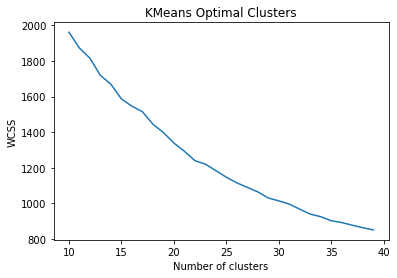

In [48]:
#Find optimal clusters (****** This may take a minute *********): 
wcss = []
for i in range(10, 40):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(final_topic_features)
    wcss.append(kmeans.inertia_)
plt.plot(range(10, 40), wcss)
plt.title('KMeans Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

We are looking for a bend or "elbow" in the curve that represents a point of diminishing returns. If we choose a broader range (say, 1 - 90) we would see a bend at around 30 clusters. We will choose this value for our cluster parameter. 

In [49]:
#Select the 30-cluster model and view results: 
kmeans = KMeans(n_clusters =30, init = 'k-means++', random_state = 42)
#Create the dependent variable, which are the clusters KMeans assigns to each person
y_kmeans = kmeans.fit_predict(final_topic_features)

In [50]:
#Look at a sample of cluster assignments
print(y_kmeans)

[24 24 24 ... 12 15 29]


#### Visualize Results

To visualize the results of our clustering algorithm, we first need to reduce the dimensions of our data and centroids produced by the KMeans model

In [51]:
from sklearn.decomposition import PCA

#Use PCA to reduce dimensions of our dataset
pca = PCA(n_components=2)

#Fit the model to our data: 
pca.fit(final_topic_features)

#Transform the model data: 
x_pca = pca.transform(final_topic_features)

print(final_topic_features.shape)
print('\n')
print(x_pca.shape)


#Add principal components to a dataframe we can use to plot individual points on our scatterplot
df_pca = pd.DataFrame(index=final_topic_features.index)
df_pca['pca1'] = x_pca[:,0]
df_pca['pca2'] = x_pca[:,1]
df_pca['clusters_noscaled'] = y_kmeans
print(df_pca.tail())

#Use PCA to reduce dimensions of the centroids
pca_ctr = PCA(n_components=2)

#Fit the model to the centroid data: 
pca_ctr.fit(kmeans.cluster_centers_)

#Transform the centroid data: 
ctr_pca = pca_ctr.transform(kmeans.cluster_centers_)

print(kmeans.cluster_centers_.shape)
print('\n')
print(ctr_pca.shape)

(14141, 24)


(14141, 2)
                            pca1      pca2  clusters_noscaled
Person                                                       
zorichb@epenergy.com   -0.128080 -0.138940                  6
zpatterson@ccemtl.org  -0.050760  0.201763                  9
zuela.carter@enron.com -0.107999 -0.054994                 12
zulie.flores@enron.com  0.165235 -0.089495                 15
zwharton@dawray.com    -0.067940  0.050723                 29
(30, 24)


(30, 2)


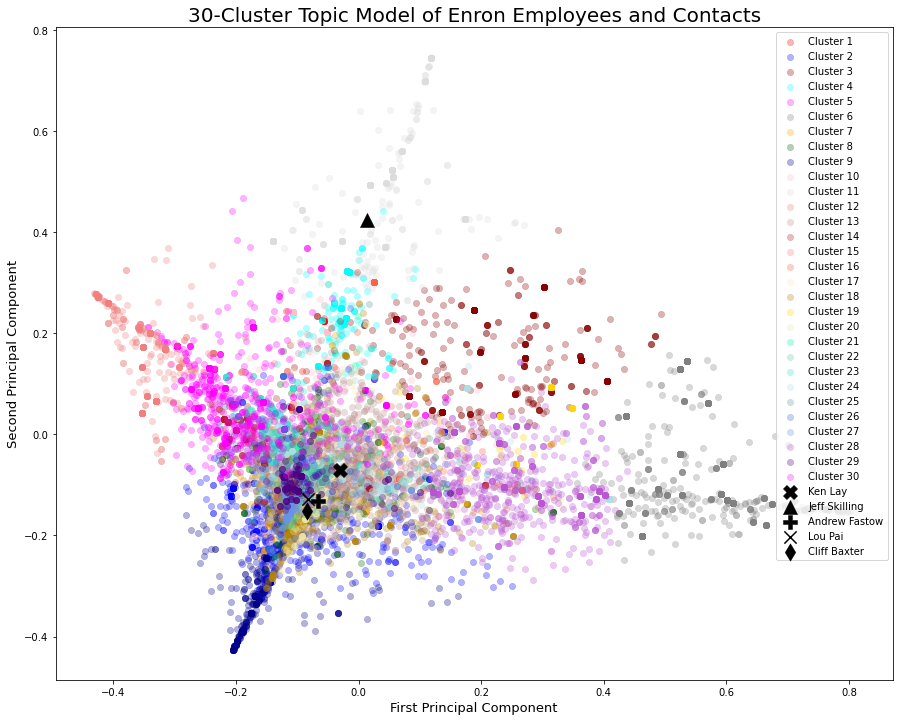

In [52]:
#Plot the cluster data, coloring the plot by cluster assignment: 
plt.figure(figsize = (15,12))
plt.scatter(x_pca[y_kmeans==0,0],x_pca[y_kmeans==0,1], s = 40, alpha=.3, linewidths=.5, c = 'red', label = 'Cluster 1')
plt.scatter(x_pca[y_kmeans==1,0],x_pca[y_kmeans==1,1], s = 40, alpha=.3, linewidths=.5, c = 'blue', label = 'Cluster 2')
plt.scatter(x_pca[y_kmeans==2,0],x_pca[y_kmeans==2,1], s = 40, alpha=.3, linewidths=.5, c = 'darkred', label = 'Cluster 3')
plt.scatter(x_pca[y_kmeans==3,0],x_pca[y_kmeans==3,1], s = 40, alpha=.3, linewidths=.5, c = 'cyan', label = 'Cluster 4')
plt.scatter(x_pca[y_kmeans==4,0],x_pca[y_kmeans==4,1], s = 40, alpha=.3, linewidths=.5, c = 'magenta', label = 'Cluster 5')
plt.scatter(x_pca[y_kmeans==5,0],x_pca[y_kmeans==5,1], s = 40, alpha=.3, linewidths=.5, c = 'gray', label = 'Cluster 6')
plt.scatter(x_pca[y_kmeans==6,0],x_pca[y_kmeans==6,1], s = 40, alpha=.3, linewidths=.5, c = 'orange', label = 'Cluster 7')
plt.scatter(x_pca[y_kmeans==7,0],x_pca[y_kmeans==7,1], s = 40, alpha=.3, linewidths=.5, c = 'darkgreen', label = 'Cluster 8')
plt.scatter(x_pca[y_kmeans==8,0],x_pca[y_kmeans==8,1], s = 40, alpha=.3, linewidths=.5, c = 'darkblue', label = 'Cluster 9')
plt.scatter(x_pca[y_kmeans==9,0],x_pca[y_kmeans==9,1], s = 40, alpha=.3, linewidths=.5, c = 'pink', label = 'Cluster 10')

plt.scatter(x_pca[y_kmeans==10,0],x_pca[y_kmeans==10,1], s = 40, alpha=.3, linewidths=.5, c = 'gainsboro', label = 'Cluster 11')
plt.scatter(x_pca[y_kmeans==11,0],x_pca[y_kmeans==11,1], s = 40, alpha=.3, linewidths=.5, c = 'lightcoral', label = 'Cluster 12')
plt.scatter(x_pca[y_kmeans==12,0],x_pca[y_kmeans==12,1], s = 40, alpha=.3, linewidths=.5, c = 'rosybrown', label = 'Cluster 13')
plt.scatter(x_pca[y_kmeans==13,0],x_pca[y_kmeans==13,1], s = 40, alpha=.3, linewidths=.5, c = 'firebrick', label = 'Cluster 14')
plt.scatter(x_pca[y_kmeans==14,0],x_pca[y_kmeans==14,1], s = 40, alpha=.3, linewidths=.5, c = 'salmon', label = 'Cluster 15')
plt.scatter(x_pca[y_kmeans==15,0],x_pca[y_kmeans==15,1], s = 40, alpha=.3, linewidths=.5, c = 'tomato', label = 'Cluster 16')
plt.scatter(x_pca[y_kmeans==16,0],x_pca[y_kmeans==16,1], s = 40, alpha=.3, linewidths=.5, c = 'bisque', label = 'Cluster 17')
plt.scatter(x_pca[y_kmeans==17,0],x_pca[y_kmeans==17,1], s = 40, alpha=.3, linewidths=.5, c = 'darkgoldenrod', label = 'Cluster 18')
plt.scatter(x_pca[y_kmeans==18,0],x_pca[y_kmeans==18,1], s = 40, alpha=.3, linewidths=.5, c = 'gold', label = 'Cluster 19')
plt.scatter(x_pca[y_kmeans==19,0],x_pca[y_kmeans==19,1], s = 40, alpha=.3, linewidths=.5, c = 'palegoldenrod', label = 'Cluster 20')

plt.scatter(x_pca[y_kmeans==20,0],x_pca[y_kmeans==20,1], s = 40, alpha=.3, linewidths=.5, c = 'mediumspringgreen', label = 'Cluster 21')
plt.scatter(x_pca[y_kmeans==21,0],x_pca[y_kmeans==21,1], s = 40, alpha=.3, linewidths=.5, c = 'mediumaquamarine', label = 'Cluster 22')
plt.scatter(x_pca[y_kmeans==22,0],x_pca[y_kmeans==22,1], s = 40, alpha=.3, linewidths=.5, c = 'turquoise', label = 'Cluster 23')
plt.scatter(x_pca[y_kmeans==23,0],x_pca[y_kmeans==23,1], s = 40, alpha=.3, linewidths=.5, c = 'powderblue', label = 'Cluster 24')
plt.scatter(x_pca[y_kmeans==24,0],x_pca[y_kmeans==24,1], s = 40, alpha=.3, linewidths=.5, c = 'cadetblue', label = 'Cluster 25')
plt.scatter(x_pca[y_kmeans==25,0],x_pca[y_kmeans==25,1], s = 40, alpha=.3, linewidths=.5, c = 'royalblue', label = 'Cluster 26')
plt.scatter(x_pca[y_kmeans==26,0],x_pca[y_kmeans==26,1], s = 40, alpha=.3, linewidths=.5, c = 'cornflowerblue', label = 'Cluster 27')
plt.scatter(x_pca[y_kmeans==27,0],x_pca[y_kmeans==27,1], s = 40, alpha=.3, linewidths=.5, c = 'mediumorchid', label = 'Cluster 28')
plt.scatter(x_pca[y_kmeans==28,0],x_pca[y_kmeans==28,1], s = 40, alpha=.3, linewidths=.5, c = 'indigo', label = 'Cluster 29')
plt.scatter(x_pca[y_kmeans==29,0],x_pca[y_kmeans==29,1], s = 40, alpha=.3, linewidths=.5, c = 'fuchsia', label = 'Cluster 30')

#Plot the points where our known fraudsters are located: 
plt.scatter(df_pca.loc['kenneth.lay@enron.com'][0], df_pca.loc['kenneth.lay@enron.com'][1], s = 200, linewidths=.5, c = 'black', marker = 'X', label = 'Ken Lay')
plt.scatter(df_pca.loc['jeff.skilling@enron.com'][0], df_pca.loc['jeff.skilling@enron.com'][1], s = 200, linewidths=.5, c = 'black', marker = '^', label = 'Jeff Skilling')
plt.scatter(df_pca.loc['andrew.fastow@enron.com'][0], df_pca.loc['andrew.fastow@enron.com'][1], s = 200, linewidths=.5, c = 'black', marker = 'P', label = 'Andrew Fastow')
plt.scatter(df_pca.loc['lou.pai@enron.com'][0], df_pca.loc['lou.pai@enron.com'][1], s = 150, linewidths=.5, c = 'black', marker = 'x', label = 'Lou Pai')
plt.scatter(df_pca.loc['cliff.baxter@enron.com'][0], df_pca.loc['cliff.baxter@enron.com'][1], s = 150, linewidths=.5, c = 'black', marker = 'd', label = 'Cliff Baxter')

#plt.scatter(ctr_pca20[:, 0], ctr_pca20[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('30-Cluster Topic Model of Enron Employees and Contacts', fontsize=20)
plt.xlabel("First Principal Component", fontsize=13)
plt.ylabel("Second Principal Component", fontsize=13)
plt.legend()
plt.show()

### 2. KMeans Clustering - Scaled data

Now we use the normalized or scaled data and see how this clusters using K-Means

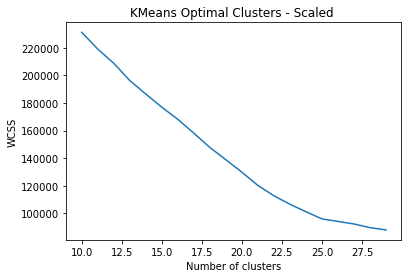

In [53]:
#Find optimal clusters: 
wcss = []
for i in range(10, 30):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(final_topic_features_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(10, 30), wcss)
plt.title('KMeans Optimal Clusters - Scaled ')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

##### For the scaled version, we see a bend at 25-clusters. Let's take a look at what we get:

In [54]:
#Select the 25-cluster model and view results: 
kmeans2 = KMeans(n_clusters = 25, init = 'k-means++', random_state = 42)
#Create the dependent variable, which are the clusters KMeans assigns to each person
y_kmeans2 = kmeans2.fit_predict(final_topic_features_scaled)

print(y_kmeans2)

[18 18 18 ... 22 23 14]


#### Visualize Results of Scaled Cluster Model

To visualize the results of our clustering algorithm, we first need to reduce the dimensions of our data and centroids produced by the KMeans model


In [55]:
#Use PCA to reduce dimensions of our dataset
pca2 = PCA(n_components=2)

#Fit the model to our data: 
pca2.fit(final_topic_features_scaled)

#Transform the model data: 
x_pca2 = pca2.transform(final_topic_features_scaled)

print(final_topic_features_scaled.shape)
print('\n')
print(x_pca2.shape)

#Add principal components to a dataframe we can use to plot individual points on our scatterplot
df_pca2 = pd.DataFrame(index=final_topic_features_scaled.index)
df_pca2['pca1'] = x_pca2[:,0]
df_pca2['pca2'] = x_pca2[:,1]
df_pca2['clusters-scaled'] = y_kmeans2
print(df_pca2.tail())

#Use PCA to reduce dimensions of the 2-cluster centroids
pca_ctr2 = PCA(n_components=2)

#Fit the model to the centroid data: 
pca_ctr2.fit(kmeans2.cluster_centers_)

#Transform the centroid data: 
ctr_pca2 = pca_ctr2.transform(kmeans2.cluster_centers_)

print(kmeans2.cluster_centers_.shape)
print('\n')
print(ctr_pca2.shape)

(14141, 24)


(14141, 2)
                            pca1      pca2  clusters-scaled
Person                                                     
zorichb@epenergy.com    3.688642  4.479197               13
zpatterson@ccemtl.org  -0.879127 -0.407979                1
zuela.carter@enron.com  0.450630  0.721535               22
zulie.flores@enron.com -0.390384  0.022891               23
zwharton@dawray.com    -0.054184 -0.014275               14
(25, 24)


(25, 2)


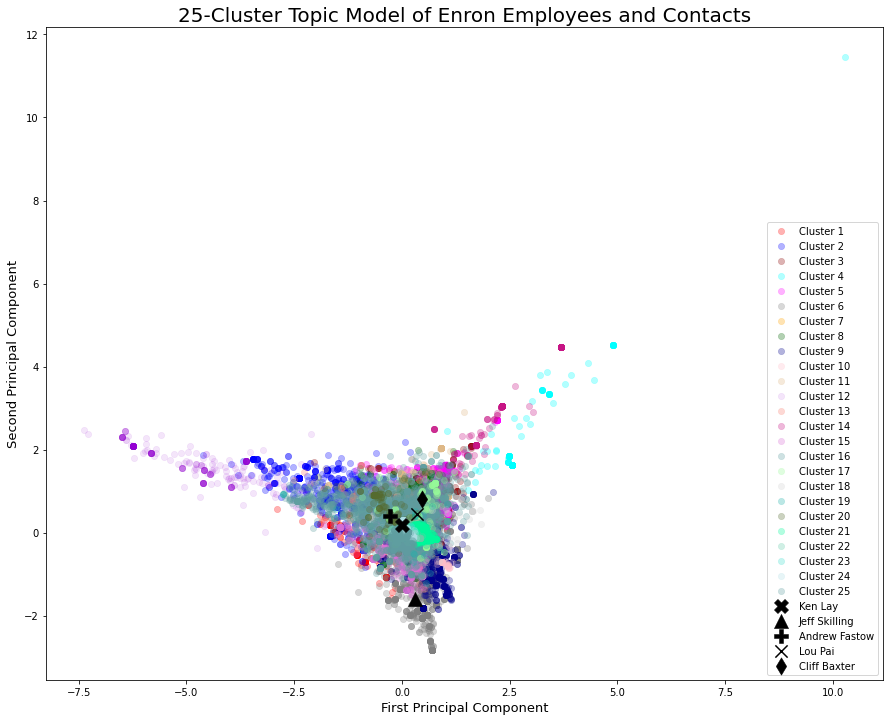

In [56]:
#Plot the clusters from the standardized data, coloring the plot by cluster assignment: 
plt.figure(figsize = (15,12))
plt.scatter(x_pca2[y_kmeans2==0,0],x_pca2[y_kmeans2==0,1], s = 40, alpha=.3, linewidths=.5, c = 'red', label = 'Cluster 1')
plt.scatter(x_pca2[y_kmeans2==1,0],x_pca2[y_kmeans2==1,1], s = 40, alpha=.3, linewidths=.5, c = 'blue', label = 'Cluster 2')
plt.scatter(x_pca2[y_kmeans2==2,0],x_pca2[y_kmeans2==2,1], s = 40, alpha=.3, linewidths=.5, c = 'darkred', label = 'Cluster 3')
plt.scatter(x_pca2[y_kmeans2==3,0],x_pca2[y_kmeans2==3,1], s = 40, alpha=.3, linewidths=.5, c = 'cyan', label = 'Cluster 4')
plt.scatter(x_pca2[y_kmeans2==4,0],x_pca2[y_kmeans2==4,1], s = 40, alpha=.3, linewidths=.5, c = 'magenta', label = 'Cluster 5')
plt.scatter(x_pca2[y_kmeans2==5,0],x_pca2[y_kmeans2==5,1], s = 40, alpha=.3, linewidths=.5, c = 'gray', label = 'Cluster 6')
plt.scatter(x_pca2[y_kmeans2==6,0],x_pca2[y_kmeans2==6,1], s = 40, alpha=.3, linewidths=.5, c = 'orange', label = 'Cluster 7')
plt.scatter(x_pca2[y_kmeans2==7,0],x_pca2[y_kmeans2==7,1], s = 40, alpha=.3, linewidths=.5, c = 'darkgreen', label = 'Cluster 8')
plt.scatter(x_pca2[y_kmeans2==8,0],x_pca2[y_kmeans2==8,1], s = 40, alpha=.3, linewidths=.5, c = 'darkblue', label = 'Cluster 9')
plt.scatter(x_pca2[y_kmeans2==9,0],x_pca2[y_kmeans2==9,1], s = 40, alpha=.3, linewidths=.5, c = 'pink', label = 'Cluster 10')

plt.scatter(x_pca2[y_kmeans2==10,0],x_pca2[y_kmeans2==10,1], s = 40, alpha=.3, linewidths=.5, c = 'burlywood', label = 'Cluster 11')
plt.scatter(x_pca2[y_kmeans2==11,0],x_pca2[y_kmeans2==11,1], s = 40, alpha=.1, linewidths=.5, c = 'darkviolet', label = 'Cluster 12')
plt.scatter(x_pca2[y_kmeans2==12,0],x_pca2[y_kmeans2==12,1], s = 40, alpha=.3, linewidths=.5, c = 'salmon', label = 'Cluster 13')
plt.scatter(x_pca2[y_kmeans2==13,0],x_pca2[y_kmeans2==13,1], s = 40, alpha=.3, linewidths=.5, c = 'mediumvioletred', label = 'Cluster 14')
plt.scatter(x_pca2[y_kmeans2==14,0],x_pca2[y_kmeans2==14,1], s = 40, alpha=.3, linewidths=.5, c = 'orchid', label = 'Cluster 15')
plt.scatter(x_pca2[y_kmeans2==15,0],x_pca2[y_kmeans2==15,1], s = 40, alpha=.3, linewidths=.5, c = 'cadetblue', label = 'Cluster 16')
plt.scatter(x_pca2[y_kmeans2==16,0],x_pca2[y_kmeans2==16,1], s = 40, alpha=.3, linewidths=.5, c = 'palegreen', label = 'Cluster 17')
plt.scatter(x_pca2[y_kmeans2==17,0],x_pca2[y_kmeans2==17,1], s = 40, alpha=.3, linewidths=.5, c = 'lightgray', label = 'Cluster 18')
plt.scatter(x_pca2[y_kmeans2==18,0],x_pca2[y_kmeans2==18,1], s = 40, alpha=.3, linewidths=.5, c = 'lightseagreen', label = 'Cluster 19')
plt.scatter(x_pca2[y_kmeans2==19,0],x_pca2[y_kmeans2==19,1], s = 40, alpha=.3, linewidths=.5, c = 'darkolivegreen', label = 'Cluster 20')

plt.scatter(x_pca[y_kmeans2==20,0],x_pca[y_kmeans2==20,1], s = 40, alpha=.3, linewidths=.5, c = 'mediumspringgreen', label = 'Cluster 21')
plt.scatter(x_pca[y_kmeans2==21,0],x_pca[y_kmeans2==21,1], s = 40, alpha=.3, linewidths=.5, c = 'mediumaquamarine', label = 'Cluster 22')
plt.scatter(x_pca[y_kmeans2==22,0],x_pca[y_kmeans2==22,1], s = 40, alpha=.3, linewidths=.5, c = 'turquoise', label = 'Cluster 23')
plt.scatter(x_pca[y_kmeans2==23,0],x_pca[y_kmeans2==23,1], s = 40, alpha=.3, linewidths=.5, c = 'powderblue', label = 'Cluster 24')
plt.scatter(x_pca[y_kmeans2==24,0],x_pca[y_kmeans2==24,1], s = 40, alpha=.3, linewidths=.5, c = 'cadetblue', label = 'Cluster 25')

#plt.scatter(ctr_pca2[:, 0], ctr_pca2[:, 1], s = 300, c = 'yellow', label = 'Centroids')

#Add points for our known fraudsters: 
plt.scatter(df_pca2.loc['kenneth.lay@enron.com'][0], df_pca2.loc['kenneth.lay@enron.com'][1], s = 200, linewidths=.5, c = 'black', marker = 'X', label = 'Ken Lay')
plt.scatter(df_pca2.loc['jeff.skilling@enron.com'][0], df_pca2.loc['jeff.skilling@enron.com'][1], s = 200, linewidths=.5, c = 'black', marker = '^', label = 'Jeff Skilling')
plt.scatter(df_pca2.loc['andrew.fastow@enron.com'][0], df_pca2.loc['andrew.fastow@enron.com'][1], s = 200, linewidths=.5, c = 'black', marker = 'P', label = 'Andrew Fastow')
plt.scatter(df_pca2.loc['lou.pai@enron.com'][0], df_pca2.loc['lou.pai@enron.com'][1], s = 150, linewidths=.5, c = 'black', marker = 'x', label = 'Lou Pai')
plt.scatter(df_pca2.loc['cliff.baxter@enron.com'][0], df_pca2.loc['cliff.baxter@enron.com'][1], s = 150, linewidths=.5, c = 'black', marker = 'd', label = 'Cliff Baxter')

plt.title('25-Cluster Topic Model of Enron Employees and Contacts', fontsize=20)
plt.xlabel("First Principal Component", fontsize=13)
plt.ylabel("Second Principal Component", fontsize=13)
plt.legend()
plt.show()

### Let's find out which cluster Jeffrey Skilling, Ken Lay, Andrew Fastow, Lou Pai & J. Clifford Baxter are in. 

Are they in the same cluster? Who else is with them? 

In [57]:
ken_kmean = int(df_pca.loc['kenneth.lay@enron.com']['clusters_noscaled'])
jeff_kmean = int(df_pca.loc['jeff.skilling@enron.com']['clusters_noscaled'])
andy_kmean = int(df_pca.loc['andrew.fastow@enron.com']['clusters_noscaled'])
lou_kmean = int(df_pca.loc['lou.pai@enron.com']['clusters_noscaled'])
cliff_kmean = int(df_pca.loc['cliff.baxter@enron.com']['clusters_noscaled'])

print('Cluster Assignments of Fraudsters Using All Topic Features via 30-Cluster Kmeans without feature scaling:')
print('--------------------------------------------------------------------------------------------------------')
print('Ken : ' + str(ken_kmean))
#print('\n')
print('Jeff : ' + str(jeff_kmean))
#print('\n')
print('Andy : ' + str(andy_kmean))
#print('\n')
print('Lou : ' + str(lou_kmean))
#print('\n')
print('Cliff : ' + str(cliff_kmean))
print('\n')
#print('--------------------------------------------------------')

#How many people are in each of these subsets? 
print("Group sizes:")
print('-----------')
print("Ken & Andy:  ", len(df_pca[df_pca['clusters_noscaled']==ken_kmean]))
print("Jeff:  ", len(df_pca[df_pca['clusters_noscaled']==jeff_kmean]))
print("Lou:  ", len(df_pca[df_pca['clusters_noscaled']==lou_kmean]))
print("Cliff:  ", len(df_pca[df_pca['clusters_noscaled']==cliff_kmean]))
print("Everyone Else:  ", len(df_pca) - len(df_pca[df_pca['clusters_noscaled']==ken_kmean]) - len(df_pca[df_pca['clusters_noscaled']==jeff_kmean])-len(df_pca[df_pca['clusters_noscaled']==lou_kmean])-len(df_pca[df_pca['clusters_noscaled']==cliff_kmean]))

Cluster Assignments of Fraudsters Using All Topic Features via 30-Cluster Kmeans without feature scaling:
--------------------------------------------------------------------------------------------------------
Ken : 12
Jeff : 10
Andy : 1
Lou : 1
Cliff : 17


Group sizes:
-----------
Ken & Andy:   1275
Jeff:   900
Lou:   1028
Cliff:   603
Everyone Else:   10335


In [58]:
ken_skmean = int(df_pca2.loc['kenneth.lay@enron.com']['clusters-scaled'])
jeff_skmean = int(df_pca2.loc['jeff.skilling@enron.com']['clusters-scaled'])
andy_skmean = int(df_pca2.loc['andrew.fastow@enron.com']['clusters-scaled'])
lou_skmean = int(df_pca2.loc['lou.pai@enron.com']['clusters-scaled'])
cliff_skmean = int(df_pca2.loc['cliff.baxter@enron.com']['clusters-scaled'])

print('Cluster Assignments of Fraudsters Using All Topic Features via 25-Cluster Kmeans with feature scaling:')
print('------------------------------------------------------------------------------------------------------')
print('Ken : ' + str(ken_skmean))
#print('\n')
print('Jeff : ' + str(jeff_skmean))
#print('\n')
print('Andy : ' + str(andy_skmean))
#print('\n')
print('Lou : ' + str(lou_skmean))
#print('\n')
print('Cliff: ' + str(cliff_skmean))
print('\n')

print("Group sizes:")
print('--------------')
print("Ken & Andy:  ",len(df_pca2[df_pca2['clusters-scaled']==ken_skmean]))
print("Lou & Cliff:  ",len(df_pca2[df_pca2['clusters-scaled']==lou_skmean]))
print("Jeff:  ",len(df_pca2[df_pca2['clusters-scaled']==jeff_skmean]))
print("Everyone Else:  ", len(df_pca2) - len(df_pca2[df_pca2['clusters-scaled']==ken_skmean]) - len(df_pca2[df_pca2['clusters-scaled']==lou_skmean])-len(df_pca2[df_pca2['clusters-scaled']==jeff_skmean]))

Cluster Assignments of Fraudsters Using All Topic Features via 25-Cluster Kmeans with feature scaling:
------------------------------------------------------------------------------------------------------
Ken : 15
Jeff : 5
Andy : 15
Lou : 2
Cliff: 2


Group sizes:
--------------
Ken & Andy:   2358
Lou & Cliff:   630
Jeff:   1626
Everyone Else:   9527


# Which one do YOU think performed better? Is this good enough? 

### Proceed to "2_GraphML_Pipeline_LunchLearn-Colab.ipynb"